In [17]:
# setup code, auto reload your .py file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#schedule and timesteps
from dm.diffusion.process import linear_beta_schedule
from dm.diffusion.process import Pre

timesteps = 300
betas =linear_beta_schedule(timesteps=timesteps)
schedule = Pre(betas=betas)

q_sample = schedule.q_sample
sample = schedule.sample

In [19]:
#加载数据和数据处理
import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision.datasets import ImageFolder

dir_path = 'data/oilpainting_128'

class AnimeData(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.data = ImageFolder(root, self.transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index][0]

image_size = 32
channels = 3
batch_size = 64

transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    torchvision.transforms.RandomHorizontalFlip(),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1)
])

trainset = AnimeData(dir_path, transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [20]:
#定义model,optimization,loss_fn
from dm.modules.nn import Unet
from torch.optim import Adam
import torch.nn.functional as F

device = "cuda:1" if torch.cuda.is_available() else "cpu"
path = './model/ddpm_oil.pth'

model = Unet(dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
model.load_state_dict(torch.load(path))
model.eval()
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

def p_losses(model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [21]:
#training
epochs = 10

for epoch in range(epochs):
    for step, batch in enumerate(trainloader):
        optimizer.zero_grad()

        #random x0
        batch_size = batch.shape[0]
        batch = batch.to(device)
        
        #random t
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        #random noise
        loss = p_losses(model, batch, t, loss_type="huber")

        if step % 100 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

Loss: 0.03072444349527359
Loss: 0.030355161055922508
Loss: 0.028906121850013733
Loss: 0.02387399971485138
Loss: 0.03493070229887962
Loss: 0.02067699283361435
Loss: 0.031113121658563614
Loss: 0.021495025604963303
Loss: 0.02871876209974289
Loss: 0.02570180967450142


In [22]:
samples = sample(model, image_size=image_size, batch_size=16, channels=channels)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 300/300 [00:06<00:00, 48.29it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


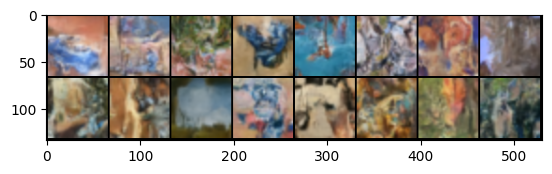

In [23]:
#reverse photo process
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Resize(64)
     #Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     #Lambda(lambda t: t * 255.),
     #Lambda(lambda t: t.numpy().astype(np.uint8)),
     #ToTensor()
])

import matplotlib.pyplot as plt
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

images = torch.tensor(samples[-1])
images = [reverse_transform(img) for img in images]

imgshow(torchvision.utils.make_grid(images))

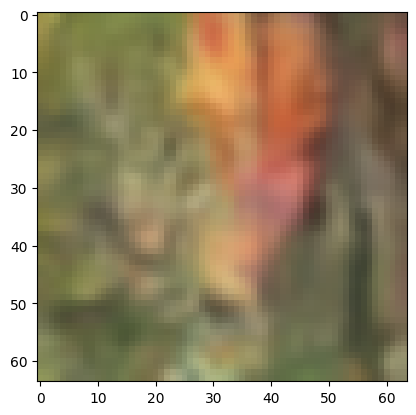

In [24]:
# show a random one
random_index = 14
plt.imshow(np.transpose(images[random_index],(1,2,0)))

#保存模型参数
path = './model/ddpm_oil.pth'
torch.save(model.state_dict(), path)